## Make some predictions using The FossilNET model

In [1]:
%load_ext autoreload
%autoreload 2

from dependencies import *

Loading dependencies we have already seen...
Importing ray...
Done...


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [4]:
class FossilResNet(nn.Module):
    
    def __init__(self, num_outputs=10):
        super(FossilResNet, self).__init__()
        
        self.model_conv = torchvision.models.resnet18(pretrained=True)
        for param in self.model_conv.parameters():
            param.requires_grad = False

        num_ftrs = self.model_conv.fc.in_features
        
        self.model_conv.fc = nn.Linear(num_ftrs, num_outputs)
        
    def forward(self, x):
        return self.model_conv(x)
        

## Load a model and check results

In [5]:
from os import path
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [46]:
fossilnet_path = path.expanduser('~/dev/swung/transform-2020-ray/datasets/fossilnet/tvt_split/4')

use_grayscale=True

test_txs = []

if use_grayscale:
    test_txs.extend([
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(0.0, 1.0)
    ])
else:
    test_txs.append(transforms.ToTensor())

#
# Loading Images from TEST
#
predict_dataset = datasets.ImageFolder(root=path.join(fossilnet_path,'test'),
                                    transform=transforms.Compose(test_txs))

predict_loader = DataLoader(predict_dataset, shuffle=True, batch_size=64)

In [49]:
X, y = list(predict_loader)[np.random.randint(0, len(predict_loader))]
print(y)

tensor([1, 1, 1, 3, 2, 1, 1, 3, 1, 2, 1, 2, 2, 2, 1, 3, 3, 0, 2, 3, 1, 1, 1, 2,
        2, 1, 2, 1, 0, 2, 1, 2, 1, 1, 3, 1, 3, 3, 1, 2, 1, 3, 3, 0, 0, 3, 2, 0,
        3, 2, 3, 3, 2, 3, 2, 0, 0, 3, 1, 2, 0, 3, 0, 3])


#### Find the model checkpoint you want to load

In [56]:
checkpoint_path = path.expanduser(path.join(
                    '~/dev/swung/transform-2020-ray/datasets',
                    'fossilnet_model/model.pth'))
print(checkpoint_path, path.exists(checkpoint_path))

/Users/stevejpurves/dev/swung/transform-2020-ray/datasets/fossilnet_model/model.pth True


In [57]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA Available :D")
else:
    device = torch.device("cpu")
    print("CPU Only :0")

with torch.set_grad_enabled(False):
    
    model = FossilResNet(num_outputs=4)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    
    model.to(device)
    
    y_ = model(X.to(device)).cpu()
    
    _, predicted = torch.max(y_, 1)

CPU Only :0


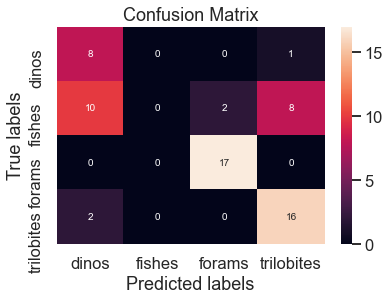

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt     
%matplotlib inline

from sklearn.metrics import confusion_matrix

labels = [0,1,2,3]
cm = confusion_matrix(y, predicted, labels)

names = ['dinos', 'fishes', 'forams', 'trilobites']

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(names);
ax.yaxis.set_ticklabels(names);

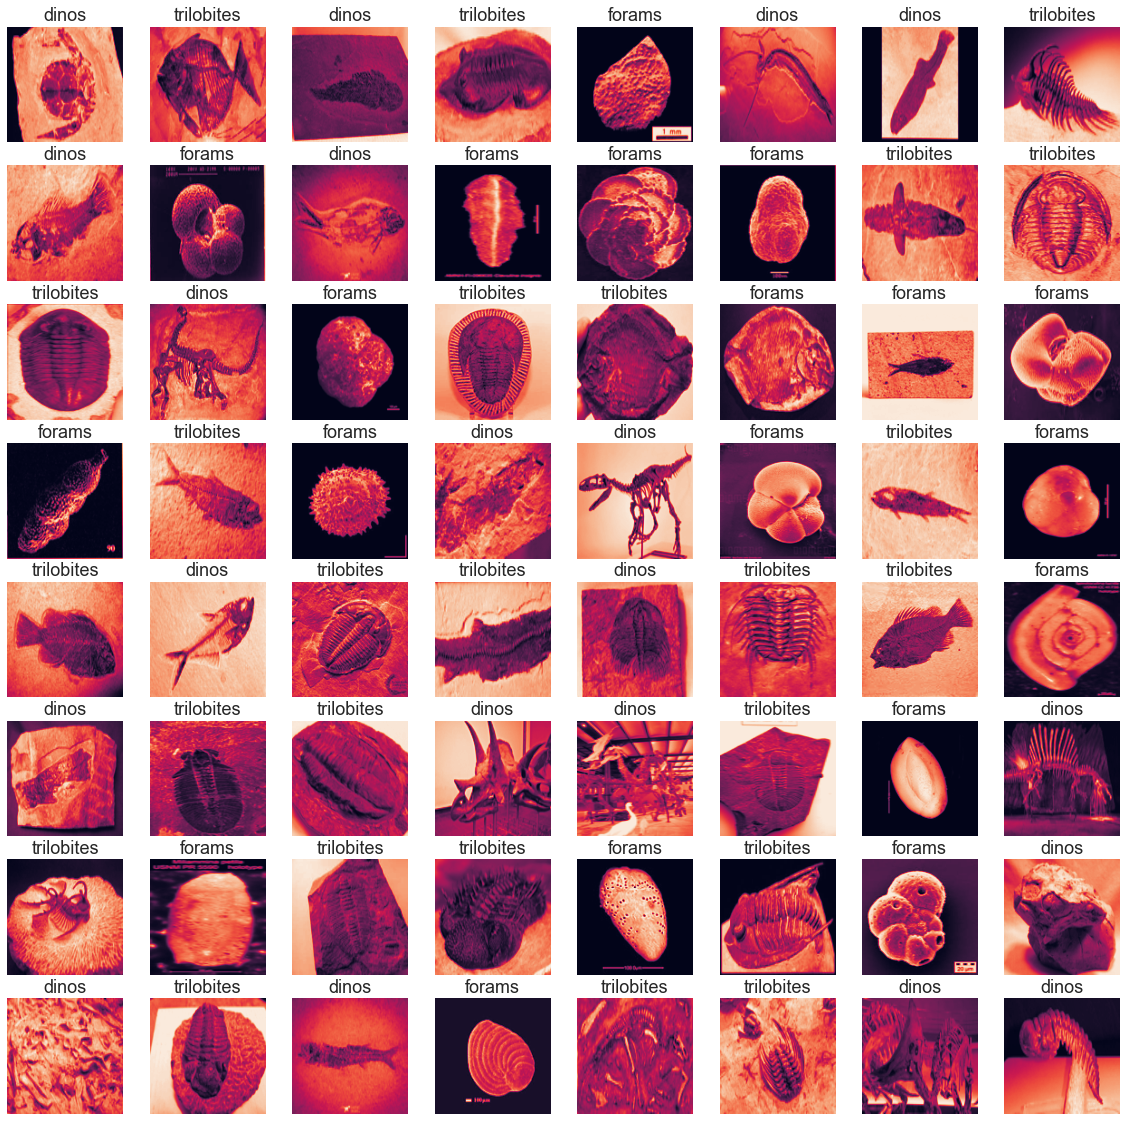

In [71]:
%matplotlib inline
fig, axs = plt.subplots(8,8, figsize=(20,20))
axsf = [item for s in axs for item in s]

for n,ax in enumerate(axsf):
    ax.imshow(X[n].squeeze().numpy()[0])
    ax.axis('off')
    ax.set_title(names[predicted[n].item()])

plt.show()